During hydrodynamic modelling in data-scarce areas, we frequently observe problems with the used space-based elevation records such as SRTM. Very popular ways of dealing with this in hydrology is to simply dig a very deep channel that carves through the landscape, or fill up pit cells at places where known channels are located, to ensure that water always eventually flows into the ocean.

For hydraulics (in particular 1D modelling), hydraulic connectivity is very important and care should be taken that the elevation along the river network is as realistically as possible. 1D drainage networks based upon space-borne elevation usually follow more or less the centrelines of channels, but problems occur if channel elevation profiles are obscure due to vegetaion within the channel, noise or islands. This problem was recognized by Yamazaki et al. and an approach to carefully dig and fill elevation to fix this was developed. Yamazaki's algorithm was reprogrammed in python by Hessel Winsemius and Tarasinta Perwitasari and can now be applied on any gridded elevation dataset with drainage network.

This notebook explains the problem further and shows how the hydrotools digging and filling algorithm (dem_fill_dig) works with an example over Curacao.


In [1]:
import hydrotools.gis as gis
import matplotlib.pyplot as plt
import numpy as np
import dem_fill_dig_strahler as dem_fill_new
import time
%matplotlib inline

Let's load an elevation model and drainage direction data. These need to have the same number of rows/columns and be on the same geographical region (of course...). Here we use PCRaster based drainage directions, but the array of drainage directions can also be defined using a 3x3 numpy array.

We'll make a quick plot to see our data

<matplotlib.colorbar.Colorbar instance at 0x0000000019A84E48>

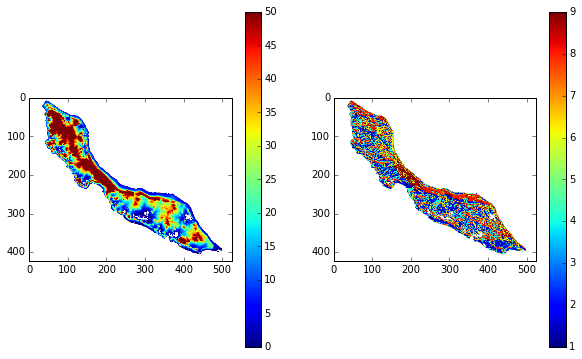

In [2]:
dem_file = r'data\curacao_dem.map'
ldd_file = r'data\curacao_ldd.map'
x, y, dem, dem_fill = gis.gdal_readmap(dem_file, 'PCRaster')
x, y, ldd, ldd_fill = gis.gdal_readmap(ldd_file, 'PCRaster')

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(np.ma.masked_equal(dem, dem_fill), vmin=0., vmax=50)
plt.colorbar()
plt.subplot(122)
plt.imshow(np.ma.masked_equal(ldd, ldd_fill))
plt.colorbar()


now let's investigate some points a bit further, we made a nice function that can retrieve the downstream point along a stream line. So we can extract the whole streamline, giving only a starting point of the stream. We will end at a pit cell. From this list we can extract the elevation like so:

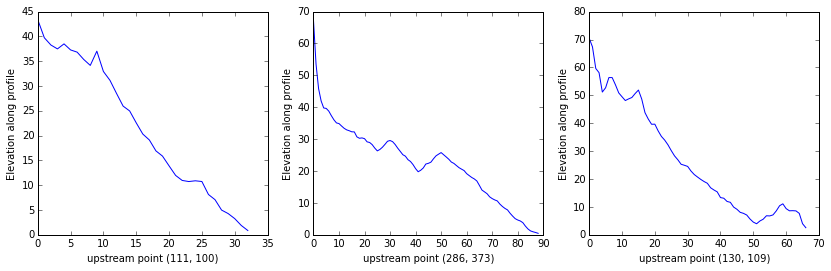

In [3]:
some_points_upstream = [(111, 100), (286, 373), (130, 109)]
pit = 5  # this is the number attributed to a pit cell
plt.figure(figsize=(14, 4))

for n, point_up in enumerate(some_points_upstream):
    plt.subplot(1, 3, n + 1)
    # find the whole stream line and retrieve elevation
    idx_down = [point_up]
    idx_next = gis.find_downstream(ldd, point_up[0], point_up[1])
    while ldd[idx_next] != pit:
        idx_down.append(idx_next)
        idx_next = gis.find_downstream(ldd, idx_next[0], idx_next[1])

    # now we have a bunch of idxs, get the elevation and plot!
    plt.plot(dem[zip(*idx_down)])
    plt.xlabel('upstream point {:s}'.format(str(point_up)))
    plt.ylabel('Elevation along profile')


These figures clearly demonstrate the problem: there are bumps in the elevation along the stream line that will certaintly compromise hydraulic simulations. The 'bumps' may be due to insufficient resolution (the case here in Curacao given the coarse resolution of the elevation of about 100 meter and the small dimensions of channels, about ~10 meter) or due to islands, vegetation or even elevation data noise. Now let's try to solve this problem. The function dem_fill_dig will dig out or fill elevation pixels along stream lines sequentially across all streamlines within the elevation domain. Whether you prefer digging or filling can be established with penalty weights. A high penalty weight for digging means that the algorithm will prefer filling pixels, while the reverse is true for a high penalty weight for filling.

First we use the old algorithm to produce a filled dem and check amount of time needed

In [4]:
a = time.time()
dem_mod = gis.dem_fill_dig(dem, ldd, dem_fill, ldd_fill, pit, weight_fill=1.,
                 weight_dig=5., z_int=0.05,
                 flow_dirs=np.array([[7, 8, 9], [4, 5, 6], [1, 2, 3]]))
b = time.time()
print('Old algorithm took {:1.5f} seconds'.format(b-a))

Preparing new dem
Old algorithm took 9.38600 seconds


In [5]:
a = time.time()
dem_mod_new, strahler = dem_fill_new.dem_fill_dig(dem, ldd, dem_fill, ldd_fill, pit, weight_fill=1.,
                 weight_dig=5., z_int=0.05,
                 flow_dirs=np.array([[7, 8, 9], [4, 5, 6], [1, 2, 3]]))
b = time.time()
print('New algorithm took only {:1.5f} seconds. Haha!!!'.format(b-a))

Preparing strahler order 1 with 16143 start points
Preparing new dem
Preparing Strahler order map
Preparing strahler order 2 with 3416 start points
Preparing strahler order 3 with 751 start points
Preparing strahler order 4 with 168 start points
Preparing strahler order 5 with 32 start points
Preparing strahler order 6 with 4 start points
Filling missing data
New algorithm took only 6.02400 seconds. Haha!!!


Let's investigate what the two modified DEMs look like compared to the original. First we make 2 difference plots between the old and new dem

<matplotlib.colorbar.Colorbar instance at 0x00000000209C0488>

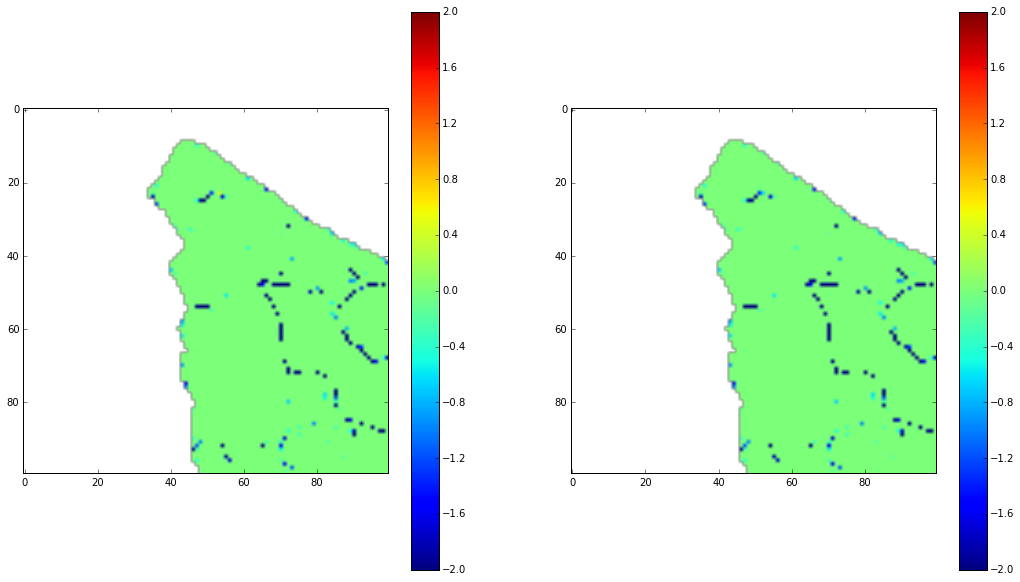

In [13]:
plt.figure(figsize=(18, 10))
plt.subplot(121)
plt.imshow(np.ma.masked_equal(dem_mod[0:100, 0:100], dem_fill)-dem[0:100, 0:100], vmin=-2, vmax=2)
#plt.figure(figsize=(10,10))
#plt.imshow(np.ma.masked_equal(strahler[0:80, 0:80], dem_fill), interpolation='nearest')
#strahler[np.isnan(strahler)] = dem_fill
plt.colorbar()
plt.subplot(122)
plt.imshow(np.ma.masked_equal(dem_mod_new[0:100, 0:100], dem_fill)-dem[0:100, 0:100], vmin=-2, vmax=2)
plt.colorbar()

#gis.gdal_writemap('strahler.map', 'PCRaster', x, y, strahler, dem_fill)

Let's plot differences between old and new method

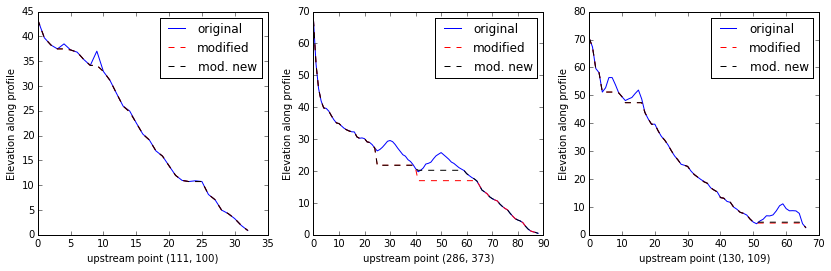

In [10]:
plt.figure(figsize=(14, 4))

for n, point_up in enumerate(some_points_upstream):
    plt.subplot(1, 3, n + 1)
    # find the whole stream line and retrieve elevation
    idx_down = [point_up]
    idx_next = gis.find_downstream(ldd, point_up[0], point_up[1])
    while ldd[idx_next] != pit:
        idx_down.append(idx_next)
        idx_next = gis.find_downstream(ldd, idx_next[0], idx_next[1])

    # now we have a bunch of idxs, get the elevation and plot!
    plt.plot(dem[zip(*idx_down)])
    plt.plot(dem_mod[zip(*idx_down)], 'r--')
    plt.plot(dem_mod_new[zip(*idx_down)], 'k--')
    plt.legend(('original', 'modified', 'mod. new'))
    plt.xlabel('upstream point {:s}'.format(str(point_up)))
    plt.ylabel('Elevation along profile')


And a diff between old and new method

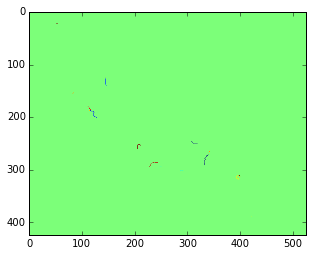

In [11]:
plt.imshow(dem_mod-dem_mod_new, vmin=-0.5, vmax=0.5)